## 数据聚合与分组操作

对数据集进行分组并对各组应用一个函数（无论是聚合还是转换），通常是数据分析工作中的重要环节。

pandas提供了一个灵活高效的gruopby功能，它使你能以一种自然的方式对数据集进行切片、切块、摘要等操作。

## 一.GroupBy机制

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'key1':['a','b','b','b','a'],'key2':['one','two','one','two','one'],
                   'data1': np.random.randn(5),'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.404594,0.770595
1,b,two,-0.793531,1.157631
2,b,one,0.105604,-0.238440
3,b,two,1.228527,1.291440
4,a,one,-1.416845,1.263819


假设你想要按key1进行分组，并计算data1列的平均值。实现该功能的方式有很多，而我们这里要用的是：访问data1，并根据key1调用groupby：

In [4]:
grouped = df['data1'].groupby(df['key1'])
grouped

变量grouped是一个GroupBy对象。它实际上还没有进行任何计算，只是含有一些有关分组键df['key1']的中间数据而已

下面调用该对象的mean()方法可计算grouped的平均值

In [5]:
grouped.mean()

key1
a   -0.910719
b    0.180200
Name: data1, dtype: float64

数据（Series）根据分组键进行了聚合，产生了一个新的Series，其索引为key1列中的唯一值,索引名为key1

如果我们一次传入多个数组的列表，就会得到不同的结果：

In [6]:
means = df['data1'].groupby([df['key1'],df['key2']]).mean()
means

key1  key2
a     one    -0.910719
b     one     0.105604
      two     0.217498
Name: data1, dtype: float64

这里，我通过两个键对数据进行了分组，生成了一个拥有多层索引Series对象

In [7]:
means.unstack()

key2,one,two
key1,,
a,-0.910719,NaN
b,0.105604,0.217498


在这个例子中，分组键均为Series。实际上，分组键可以是任何长度适当的数组

In [8]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005   -0.793531
            2006    0.105604
Ohio        2005    0.411967
            2006   -1.416845
Name: data1, dtype: float64

通常，分组信息通常包含在同一个DataFrame中。这里，你还可以传递列名（可以是字符串、数字或其他Python对象）用作分组键：

In [9]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.910719,1.017207
b,0.180200,0.736877


In [10]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one  -0.910719  1.017207
b    one   0.105604 -0.238440
     two   0.217498  1.224536

你可能已经注意到了，第一个例子在执行df.groupby('key1').mean()时，结果中没有key2列。这是因为df['key2']不是数值数据，即df['key2']是一个冗余列，因此排除在结果之外。默认情况下，所有数值列都会被聚合

使用size方法，得到分组后每个组的数量信息：

In [11]:
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
b     one     1
      two     2
dtype: int64

请注意，分组键中的任何缺失值将被排除在结果之外

### 1.1.遍历各数组

groupby对象支持迭代，会生成一个包含组名和数据块的二维元组序列。考虑以下代码：

In [12]:
for name,group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one -0.404594  0.770595
4    a  one -1.416845  1.263819
b
  key1 key2     data1     data2
1    b  two -0.793531  1.157631
2    b  one  0.105604 -0.238440
3    b  two  1.228527  1.291440


对于多个分组键的情况，元组的第一个元素将会是由键值组成的元组：

In [13]:
for (k1,k2), group in df.groupby(['key1','key2']):
    print((k1,k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.404594  0.770595
4    a  one -1.416845  1.263819
('b', 'one')
  key1 key2     data1    data2
2    b  one  0.105604 -0.23844
('b', 'two')
  key1 key2     data1     data2
1    b  two -0.793531  1.157631
3    b  two  1.228527  1.291440


当然，你可以对这些数据片段做任何操作。如：将这些数据片段做成一个字典：

In [14]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,key1,key2,data1,data2
1,b,two,-0.793531,1.157631
2,b,one,0.105604,-0.238440
3,b,two,1.228527,1.291440


groupby默认是在axis=0上进行分组的，通过设置也可以在其他任何轴上进行分组。例如，我们可以根据dtype对列进行分组：

In [15]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [16]:
grouped = df.groupby(df.dtypes,axis = 1)
for dtype,group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.404594  0.770595
1 -0.793531  1.157631
2  0.105604 -0.238440
3  1.228527  1.291440
4 -1.416845  1.263819
object
  key1 key2
0    a  one
1    b  two
2    b  one
3    b  two
4    a  one


### 1.2.选择一列或所有列的子集

对于由DataFrame产生的GroupBy对象，可以通过列名称进行索引，会产生用于聚合的列子集的效果.也就是说：

In [17]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

是下面代码的语法糖

In [18]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

尤其对于大数据集，很可能只需要对部分列进行聚合。例如，在前面那个数据集中，如果只需计算data2列的平均值并以DataFrame形式得到结果，可以这样写：

In [19]:
df.groupby(['key1','key2'])[['data2']].mean()

data2
key1 key2          
a    one   1.017207
b    one  -0.238440
     two   1.224536

如果传入的是列表或数组,此索引操作所返回的对象是一个已分组的DataFrame,如果传入的是标量形式的单个列名，则分组为Series：

In [20]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [21]:
s_grouped.mean()

key1  key2
a     one     1.017207
b     one    -0.238440
      two     1.224536
Name: data2, dtype: float64

### 1.3.使用字典和Series分组

分组信息可能会以非数组形式存在：

In [22]:
people = pd.DataFrame(np.random.randn(5, 5), columns = ['a','b','c','d','e'],index = ['Joe','Steve','Wes','Jim','Travis'])
people

,a,b,c,d,e
Joe,1.065004,-1.445237,1.274220,0.214923,0.599501
Steve,-0.032375,-0.226332,-1.611425,-0.131072,-1.308837
Wes,-1.631231,-1.742401,0.414694,-1.054268,-0.243827
Jim,0.067533,-1.007009,-0.190632,2.042537,0.573049
Travis,0.497642,-0.321329,1.721515,-1.648964,-1.319648


In [23]:
people.iloc[2:3,[1,2]] = np.nan
people

,a,b,c,d,e
Joe,1.065004,-1.445237,1.274220,0.214923,0.599501
Steve,-0.032375,-0.226332,-1.611425,-0.131072,-1.308837
Wes,-1.631231,NaN,NaN,-1.054268,-0.243827
Jim,0.067533,-1.007009,-0.190632,2.042537,0.573049
Travis,0.497642,-0.321329,1.721515,-1.648964,-1.319648


现在，假设我拥有各列的分组对应关系，并且想把各列组累加：

In [24]:
mapping = {'a':'red','b':'red','c':'blue','d':'blue','e':'red','f':'orange'}

现在，你可以根据这个字典构造传给Groupby的数组

In [25]:
by_column = people.groupby(mapping, axis = 1)
by_column.sum()

,blue,red
Joe,1.489143,0.219269
Steve,-1.742497,-1.567544
Wes,-1.054268,-1.875058
Jim,1.851905,-0.366427
Travis,0.072551,-1.143336


Series也有相同的功能，可以视为固定大小的映射：

In [26]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [27]:
people.groupby(map_series,axis = 1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 1.4.使用函数分组

比起使用字典或Series，使用Python函数是一种更原生的方法定义分组映射。任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就会被用作分组名称。具体点说，以上一小节的示例DataFrame为例，其索引值为人的名字。你可以计算一个字符串长度的数组，更简单的方法是传入len函数：

In [28]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.498693,-2.452246,1.083588,1.203191,0.928723
5,-0.032375,-0.226332,-1.611425,-0.131072,-1.308837
6,0.497642,-0.321329,1.721515,-1.648964,-1.319648


将函数与数组、字典或Series进行混合并不困难，所有的对象都会在内部转换为数组:

In [29]:
key_list = ['one','one','one','two','two']
people.groupby([len,key_list]).min()

a         b         c         d         e
3 one -1.631231 -1.445237  1.274220 -1.054268 -0.243827
  two  0.067533 -1.007009 -0.190632  2.042537  0.573049
5 one -0.032375 -0.226332 -1.611425 -0.131072 -1.308837
6 two  0.497642 -0.321329  1.721515 -1.648964 -1.319648

### 1.5根据索引层级分层

分层索引的数据集能够在轴索引的某个层级上进行聚合

In [30]:
columns = pd.MultiIndex.from_arrays([['US','US','US','JP','JP'],[1,3,5,1,3]],names = ['cty','tenor'])
columns

MultiIndex([('US', 1),
            ('US', 3),
            ('US', 5),
            ('JP', 1),
            ('JP', 3)],
           names=['cty', 'tenor'])

In [31]:
hier_df = pd.DataFrame(np.random.randn(4, 5),columns = columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -1.267346 -2.353905 -1.182110 -0.904701  0.389479
1     -0.493571  1.528296 -0.002293  2.038763  1.901064
2     -0.118756  0.700109 -1.250861 -0.294549 -0.709897
3      0.562337  0.243872 -0.275137 -0.786069  0.932076

根据层级分组时，将层级数值或层级名称传递给level关键字

In [32]:
hier_df.groupby(level = 'cty',axis = 1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 二.数据聚合

聚合指的是任何能够从数组产生标量值的数据转换过程。之前的例子已经用过一些，比如mean、count、min以及sum等。你可能想知道在GroupBy对象上调用mean()时究竟发生了什么。许多常见的聚合运算（如表10-1所示）都有进行优化。然而，除了这些方法，你还可以使用其它的。

![title](img1.png)

你还可以使用自行制定的聚合，并再调用已经在分组对象上定义好的方法。例如，使用quantile方法计算Series或DataFrame列的样本分位数

虽然quantile并没有明确地实现于GroupBy，但它是一个Series方法，所以这里是能用的。实际上，GroupBy会高效地对Series进行切片，然后对各片调用piece.quantile(0.9)，最后将这些结果组装成最终结果：

In [33]:
df

,key1,key2,data1,data2
0,a,one,-0.404594,0.770595
1,b,two,-0.793531,1.157631
2,b,one,0.105604,-0.238440
3,b,two,1.228527,1.291440
4,a,one,-1.416845,1.263819


In [34]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a   -0.505819
b    1.003943
Name: data1, dtype: float64

如果要使用你自己的聚合函数，需要将函数传递给aggregate或agg方法：

In [35]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.012251,0.493223
b,2.022058,1.529880


你可能注意到注意，有些方法（如describe）也是可以用在这里的，即使严格来讲，它们并非聚合运算：

In [36]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      2.0 -0.910719  0.715770 -1.416845 -1.163782 -0.910719 -0.657657   
b      3.0  0.180200  1.013091 -0.793531 -0.343964  0.105604  0.667066   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a    -0.404594   2.0  1.017207  0.348762  0.770595  0.893901  1.017207   
b     1.228527   3.0  0.736877  0.847295 -0.238440  0.459596  1.157631   

                          
           75%       max  
key1                      
a     1.140513  1.263819  
b     1.224536  1.291440

### 2.1逐列及多函数应用

现有一个关于小费的数据集。使用read_csv导入数据之后，我们添加了一个小费百分比的列tip_pct：

In [37]:
tips = pd.read_csv('../examples/tips.csv')
tips.head()

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Sun,Dinner,2
4,24.59,3.61,No,Sun,Dinner,4


In [38]:
# 添加总账单的小费比例
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


如你所见，对Series或DataFrame列的聚合运算其实就是使用aggregate（使用自定义函数）或调用诸如mean、std之类的方法。然而，你可能希望对不同的列使用不同的聚合函数，或一次应用多个函数。其实这也好办，我将通过一些示例来进行讲解。首先，我根据day和smoker对tips进行分组：

In [39]:
grouped = tips.groupby(['day','smoker'])

注意，对于表10-1中的那些描述统计，可以将函数名以字符串的形式传入

In [40]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

如果传入一组函数或函数名，得到的DataFrame的列就会以相应的函数命名:

In [41]:
grouped_pct.agg(['mean','std',peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

如果你传递的是包含(name,function)元组的列表，那么列表中每个元组的第一个元素name将作为dataframe的列名

In [42]:
grouped_pct.agg([('foo','mean'),('bar',np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

对于DataFrame，你还有更多选择，你可以定义一组应用于全部列的一组函数，或不同的列应用不同的函数。假设我们想要对tip_pct和total_bill列计算三个统计信息：

In [43]:
functions = ['count','mean','max']
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

现在，假设你想要对一个列或不同的列应用不同的函数。具体的办法是向agg传入一个从列名映射到函数的字典：

In [44]:
grouped.agg({'tip':np.max,'size':'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [45]:
grouped.agg({'tip':['min','max','mean','std'],'size':'sum'})

tip                            size
              min    max      mean       std  sum
day  smoker                                      
Fri  No      1.50   3.50  2.812500  0.898494    9
     Yes     1.00   4.73  2.714000  1.077668   31
Sat  No      1.00   9.00  3.102889  1.642088  115
     Yes     1.00  10.00  2.875476  1.630580  104
Sun  No      1.01   6.00  3.167895  1.224785  167
     Yes     1.50   6.50  3.516842  1.261151   49
Thur No      1.25   6.70  2.673778  1.282964  112
     Yes     2.00   5.00  3.030000  1.113491   40

 ### 2.2 返回不包含索引的聚合数据

在前面的例子中，聚合数据返回时都是带有索引的，有时索引时分层的，由唯一的分组键联合形成。有些情况下是不需要索引的信息的，你可以通过向groupby传递as_index = False来禁用分组键作为索引的行为

In [49]:
tips.groupby(['day','smoker'],as_index = False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


当然，对结果调用reset_index也能得到这种形式的结果。使用as_index=False方法可以避免一些不必要的计算。

## 3.应用：通用拆分—应用—联合

GroupBy方法最常见的目的是apply(应用)，如图所示，apply会将待处理的对象拆分成多个片段，然后对各片段调用传入的函数，最后尝试将各片段组合到一起。

![](img2.png)

回到之前那个小费数据集，假设你想要根据分组选出最高的5个tip_pct值。首先，编写一个选取指定列具有最大值的行的函数：

In [59]:
def top(df, n = 5, column = 'tip_pct'):
    return df.sort_values(by = column)[-n:]
top(tips,n = 6) 

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


现在我们按照smoker进行分组，之后调用apply，我们会得到以下结果：

In [60]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

这里发生了什么？top函数在DataFrame的各个片段上调用，然后结果由pandas.concat组装到一起，并以分组名称进行了标记。于是，最终结果就有了一个层次化索引，其内层索引值来自原DataFrame。

如果你除了向apply传递函数，还传递其他参数或关键字的话，你可以把这些放在函数后进行传递

In [62]:
tips.groupby(['smoker','day']).apply(top,n = 1, column = 'total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

除这些基本用法之外，能否充分发挥apply的威力很大程度上取决于你的创造力。传入的那个函数能做什么全由你说了算，它只需返回一个pandas对象或标量值。本章后续部分的示例主要用于讲解如何利用groupby解决各种各样的问题。

### 3.1压缩分组键

从上面的例子中可以看出，分组键会跟原始对象的索引共同构成结果对象中的层次化索引。将group_keys=False传入groupby即可禁止该效果：

In [63]:
tips.groupby('smoker',group_keys = False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


### 3.2 分位数与桶分析

pandas有一些工具，比如cut和qcut，用于将数据按照你选择的箱位或样本分位数进行分桶，将这些函数跟groupby结合起来，就能非常轻松地实现对数据集的桶（bucket）或分位数（quantile）分析了。以下面这个简单的随机数据集为例，我们利用cut将其装入长度相等的桶中：

In [67]:
frame = pd.DataFrame({'data1':np.random.randn(1000),'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1,4)
quartiles[:10]

0     (0.252, 1.806]
1     (0.252, 1.806]
2    (-1.303, 0.252]
3     (0.252, 1.806]
4     (0.252, 1.806]
5     (1.806, 3.361]
6    (-1.303, 0.252]
7    (-1.303, 0.252]
8     (0.252, 1.806]
9     (0.252, 1.806]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.863, -1.303] < (-1.303, 0.252] < (0.252, 1.806] < (1.806, 3.361]]

cut返回的Categorical对象可以直接传递给groupby。所以我们可以计算出data2li列的一个统计值集合，如下：

In [70]:
def get_stats(group):
    return {'min': group.min(), 'max':group.max(),'count':group.count(),'mean':group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-2.863, -1.303]",-2.710868,2.992717,92.0,0.165303
"(-1.303, 0.252]",-2.526254,2.735427,487.0,-0.061243
"(0.252, 1.806]",-3.328877,2.802829,377.0,-0.018828
"(1.806, 3.361]",-1.759798,1.427895,44.0,-0.093645


这些都是长度相等的桶。要根据样本分位数得到大小相等的桶，使用qcut即可。传入labels=False即可只获取分位数的编号：

In [74]:
grouping = pd.qcut(frame.data1,10,labels = False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
0,-2.710868,2.992717,100.0,0.149115
1,-2.385108,2.636888,100.0,-0.074995
2,-2.295018,2.493193,100.0,0.076885
3,-2.526254,2.715298,100.0,-0.224666
4,-2.445367,2.735427,100.0,0.027808
5,-2.324920,2.093010,100.0,-0.049993
6,-2.388267,2.507358,100.0,0.039649
7,-2.246956,2.314941,100.0,-0.080262
8,-3.265304,2.181904,100.0,-0.077025


### 3.3 示例：使用指定分组值填充缺失值

对于缺失数据的清理工作，有时你会用dropna将其清除掉，而有时则可能会希望用一个固定值或由数据集本身所衍生出来的值去填充NA值。这时就得使用fillna这个工具了。在下面这个例子中，我用平均值去填充NA值：

In [77]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.507365
2         NaN
3   -0.448163
4         NaN
5    0.030761
dtype: float64

In [78]:
s.fillna(s.mean())

0    0.029988
1    0.507365
2    0.029988
3   -0.448163
4    0.029988
5    0.030761
dtype: float64

假设你需要对不同的分组填充不同的值。一种方法是将数据分组，并使用apply和一个能够对各数据块调用fillna的函数即可。下面是一些有关美国几个州的示例数据，这些州又被分为东部和西部：

In [80]:
states = ['Ohio', 'New York','Vermont','Florida','Oregon','Nevada','California','Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8),index = states)
data

Ohio          0.513595
New York     -1.956757
Vermont      -0.307583
Florida      -0.270362
Oregon        0.038539
Nevada        0.807199
California    0.635355
Idaho         0.727531
dtype: float64

让我们将数据中的一些值设为缺失值

In [81]:
data[['Vermont','Nevada','Idaho']] = np.nan
data

Ohio          0.513595
New York     -1.956757
Vermont            NaN
Florida      -0.270362
Oregon        0.038539
Nevada             NaN
California    0.635355
Idaho              NaN
dtype: float64

In [82]:
data.groupby(group_key).mean()

East   -0.571175
West    0.336947
dtype: float64

我们使用分组的平均值来填充NA值，如下：

In [85]:
fill_mean = lambda x : x.fillna(x.mean())
data.groupby(group_key).apply(fill_mean)

Ohio          0.513595
New York     -1.956757
Vermont      -0.571175
Florida      -0.270362
Oregon        0.038539
Nevada        0.336947
California    0.635355
Idaho         0.336947
dtype: float64

在另一种情况下，你可能已经在代码中为每个分组预定义了填充值。由于每个分组都有一个内置的name属性，我们可以这样使用：

In [86]:
fill_values = {'East':0.5,'West':-1}
fill_func = lambda x : x.fillna(fill_values[x.name])
data.groupby(group_key).apply(fill_func)

Ohio          0.513595
New York     -1.956757
Vermont       0.500000
Florida      -0.270362
Oregon        0.038539
Nevada       -1.000000
California    0.635355
Idaho        -1.000000
dtype: float64

### 3.4 示例：随机采样与排列

假设你想要从一个大数据集中随机抽取（进行替换或不替换）样本以进行蒙特卡罗模拟（Monte Carlo simulation）或其他应用工作。“抽取”的方式有很多，这里我们使用Series的sample方法：

In [92]:
# 红桃，黑桃，梅花，方块
suits = ['H','S','C','D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J','K','Q']
cards = []
for suit in suits:
    cards.extend(str(num) + suit for num in base_names)
deck = pd.Series(card_val,index = cards)

现在我有了一个长度为52的Series，其索引包括牌名，Series的值可以用于Blackjack或其他游戏中（为了简单起见，我当A的点数为1）：

In [93]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

现在，基于我之前说的，从这副牌中拿出五张牌可以写成：

In [97]:
def draw(deck,n = 5):
    return deck.sample(n) # 随机拿出五张牌
draw(deck)

7H      7
6D      6
KS     10
6H      6
10S    10
dtype: int64

假设你想要的从每个花色中随机抽取俩张牌。由于花色是牌名的最后一个字符，我们可以基于这点进行分组，并使用apply：

In [100]:
get_suit = lambda x : x[-1]  # 根据最后一个字符分组
deck.groupby(get_suit).apply(draw, n = 2) # 得到每个分组的随机俩个数据

C  AC     1
   KC    10
D  KD    10
   AD     1
H  8H     8
   3H     3
S  JS    10
   3S     3
dtype: int64

或者我们可以写成：

In [101]:
deck.groupby(get_suit,group_keys = False).apply(draw, n = 2)

KC    10
6C     6
2D     2
KD    10
AH     1
8H     8
3S     3
4S     4
dtype: int64

### 3.5 示例：分组加权平均和相关性

根据groupby的“拆分－应用－合并”范式，可以进行DataFrame的列与列之间或两个Series之间的运算（比如分组加权平均）。以下面这个数据集为例，它含有分组键、值以及一些权重值：

In [102]:
df = pd.DataFrame({'category':['a','a','a','a','b','b','b','b'],
                   'data': np.random.randn(8),
                   'weights': np.random.randn(8)})
df

,category,data,weights
0,a,0.165584,-1.174987
1,a,-0.662328,0.189385
2,a,0.902222,-0.153465
3,a,0.175072,1.371282
4,b,-0.322501,-1.692671
5,b,0.968265,-2.163108
6,b,0.685872,-2.411597
7,b,0.381560,0.329148


通过category进行分组加权平均如下：

In [105]:
grouped = df.groupby('category')
get_wavg = lambda x : np.average(x['data'],weights = x['weights'])
grouped.apply(get_wavg)

category
a   -0.940427
b    0.518173
dtype: float64

另一个例子，考虑一个来自Yahoo!Finance的数据集，该数据集包含一些标普500和股票的收盘价：

In [108]:
close_px = pd.read_csv('../examples/stock_px_2.csv',parse_dates = True,index_col = 0)
close_px.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


在这里我们计算SPX的百分比变化情况，可以先创建一个计算每列与SPX列成对关联的函数：

In [109]:
spx_corr = lambda x : x.corrwith(x['SPX'])

之后我们使用pct_change计算colse-px百分比变化

In [112]:
rets = close_px.pct_change().dropna()
rets # 得到每一列的百分比变化

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386
...,...,...,...,...
2011-10-10,0.051406,0.026286,0.036977,0.034125
2011-10-11,0.029526,0.002227,-0.000131,0.000544
2011-10-12,0.004747,-0.001481,0.011669,0.009795
2011-10-13,0.015515,0.008160,-0.010238,-0.002974


最后，我们按年对百分比变化进行分组，可以使用单行函数从每个行标签中提取每个datatime标签的year属性：

In [114]:
get_year = lambda x : x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


你也可以计算内部列相关性，这里我们计算了苹果和微软的年度相关性

In [115]:
by_year.apply(lambda x : x['AAPL'].corr(x['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 3.6 逐组线性回归

只要函数返回的是一个pandas对象或标量值，就可以用groupby进行分组。下面我们定义以下regress(回归)函数(使用statsmodels计量经济学库)，该函数对每个数据执行普通最小二乘(OLS)回归

In [116]:
import statsmodels.api as sm
def regress(data,yvar,xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y,X).fit()
    return result.params

现在，要计算AAPL在SPX回报上的年度线性回归，执行以下代码：

In [118]:
by_year.apply(regress,'AAPL',['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 4.数据透视表与交叉表

透视表（pivot table）是各种电子表格程序和其他数据分析软件中一种常见的数据汇总工具。它根据一个或多个键对数据进行聚合，并根据行和列上的分组键将数据分配到各个矩形区域中。在Python和pandas中，可以通过本章所介绍的groupby功能以及（能够利用层次化索引的）重塑运算制作透视表。DataFrame有一个pivot_table方法，此外还有一个顶级的pandas.pivot_table函数。除能为groupby提供便利之外，pivot_table还可以添加分项小计，也叫做margins。

回到小费数据集，假设我想要根据day和smoker计算分组平均数（pivot_table的默认聚合类型），并将day和smoker放到行上：

In [119]:
tips.(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

可以用groupby直接来做。现在，假设我们只想聚合tip_pct和size，而且想根据time进行分组。我将smoker放到列上，把day放到行上：

In [121]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

还可以对这个表作进一步的处理，传入margins=True添加分项小计。这将会添加标签为All的行和列，其值对应于单个等级中所有数据的分组统计：

In [122]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

这里，All值为平均数：不单独考虑烟民与非烟民（All列），不单独考虑行分组两个级别中的任何单项（All行）

要使用其他的聚合函数，将其传给**aggfunc**即可。例如，使用count或len可以得到有关分组大小的交叉表（计数或频率）：

In [123]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

如果存在空的组合（也就是NA），你可能会希望设置一个fill_value：

In [124]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

pivot_table的参数说明请参见下表

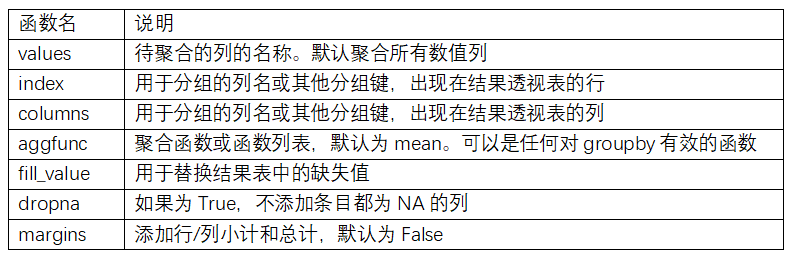

### 4.1交叉表

交叉表（cross-tabulation，简称crosstab）是一种用于计算分组频率的特殊透视表。看下面的例子：

In [ ]:
In [138]: data
Out[138]:
   Sample Nationality    Handedness
0       1         USA  Right-handed
1       2       Japan   Left-handed
2       3         USA  Right-handed
3       4       Japan  Right-handed
4       5       Japan   Left-handed
5       6       Japan  Right-handed
6       7         USA  Right-handed
7       8         USA   Left-handed
8       9       Japan  Right-handed
9      10         USA  Right-handed

作为调查分析的一部分，我们可能想要根据国籍和用手习惯对这段数据进行统计汇总。虽然可以用pivot_table实现该功能，但是pandas.crosstab函数会更方便：

In [ ]:
In [139]: pd.crosstab(data.Nationality, data.Handedness, margins=True)
Out[139]: 
Handedness   Left-handed  Right-handed  All
Nationality
Japan                  2             3    5
USA                    1             4    5
All                    3             7   10

crosstab的前两个参数可以是数组或Series，或是数组列表。就像小费数据：

In [ ]:
In [140]: pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)
Out[140]: 
smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244